In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan
import logging
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, adjusted_rand_score
logging.captureWarnings(True)
# for Linux only, load font file
# mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
np.random.seed(42)

In [2]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        try:
            id = int(i.replace("cluster_", "").replace(".png", ""))
        except ValueError:
            id = i.replace("cluster_", "").replace(".png", "")
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if len(file_list_format) > 1:
        for ax, image in zip(*[axes.reshape(-1), file_list_format]):
            fn, id = image
            img = plt.imread(prefix+"/"+fn)
            _ = ax.imshow(img)
            ax.set_title("{}".format(id))
        for ax in axes.reshape(-1):
            ax.axis("off")
    else:
        image = file_list_format[0]
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = axes.imshow(img)
        axes.set_title("{}".format(id))
        axes.axis("off")
    plt.tight_layout()

In [3]:
def simulation(fn):
    # intotal 21 nt
    data = {"TF":{}, "motif_F10": {}}
    df_TF = pd.read_csv(fn, index_col=None, header=0)
    # TFs = set(df_TF["TF"].tolist())
    # num_of_motifs =  [20000, 10000, 8000, 6000, 5000, 4000, 3000, 2000, 1000, 500, 250, 100 ]
    simu_dict = {
        "CEBPB": 10000,
        "ELF1": 4000,
        "ESR2":	2000,
        "FOXA1": 8000,
        "HAT5": 20000,
        "HOXA5":	500,
        "JUNB" :	250,
        "NFKB1" :	5000,
        "Pdx1" :1000,
        "SOX6" :	6000,
        "YY1" : 3000,
        "ZEB1" :100,
    }
    basespace = df_TF.columns[0:4]
    N = 0
    for TF, sim_num in simu_dict.items():
        motif_matrix = df_TF[df_TF["TF"] == TF]
        right_max = 21 - motif_matrix.shape[0]
        # pos = 5
        pos = np.random.randint(0, right_max)
        all_bases = []
        for idx, row in motif_matrix.iterrows():
            all_bases.append(np.random.choice(basespace, sim_num, p=row[basespace]/row[basespace].sum()))
        for i in zip(*all_bases):
            core = "".join(i)

            left = "".join(np.random.choice(basespace, pos)).lower()
            right = "".join(np.random.choice(basespace, 21 - pos - len(core))).lower()
            sim_seq = left + core + right
            data["TF"][N] = TF
            data["motif_F10"][N] = sim_seq.upper()
            N += 1
    # noise 
    for i in range(50000):
        data["TF"][N] = "random_noise"
        data["motif_F10"][N] = "".join(np.random.choice(basespace, 21))
        N += 1
    return pd.DataFrame(data)
    

In [4]:
df = simulation("TFs_v2.csv")

In [5]:
df

,TF,motif_F10
0,CEBPB,ACACAATATTACACCATGTGG
1,CEBPB,GCTAAACATTGCGTAATGCTT
2,CEBPB,TCCGTATGTTGCACAATCTTG
3,CEBPB,AATCCATATTGCATCAGCTAG
4,CEBPB,CCCTCGGGTTTCCCAATCGCA
...,...,...
109845,random_noise,TCGCCGTCGCCTGTCTACGGA
109846,random_noise,TGATCAATGATGTCACATAAC
109847,random_noise,ATATACCGTGCTGGACTCTAC
109848,random_noise,ATGACACAGAGTGAGTTTGAA


In [6]:
df.groupby("TF").count()

,motif_F10
TF,
CEBPB,10000
ELF1,4000
ESR2,2000
FOXA1,8000
HAT5,20000
HOXA5,500
JUNB,250
NFKB1,5000
Pdx1,1000


In [7]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCG"])

def onehot_enc(row):
    seq = [[i] for i in row["motif_F10"].upper()]
    return enc.transform(seq).toarray().reshape(-1)

In [8]:
onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

In [9]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, zorder=0, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

In [10]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean'):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap, metric=metric)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [11]:
def cluster_HDBSCAN(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True, optimize=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    if optimize == True:
        validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)
        param_dist = {'min_samples': [10, 50,100, 200], # 1,
                      'min_cluster_size':[100,200, 300, 500, 1000],  
                      'cluster_selection_method' : ['eom'],
                     }
        n_iter_search = 20
        '''
        random_search = RandomizedSearchCV(model
                                           ,param_distributions=param_dist
                                           ,n_iter=n_iter_search
                                           ,scoring=validity_scorer 
                                           ,random_state=42)
        '''
        grid_search = GridSearchCV(model,param_dist,scoring=validity_scorer)
        # random_search.fit(X)
        grid_search.fit(X)
        # print(random_search.best_params_)
        model = grid_search.best_estimator_
        print(grid_search.best_estimator_)
        # model = random_search.best_estimator_
    yhat = model.fit(X)
    
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    
    
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [12]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column]))  # to RNA bases .replace("T", "U")
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A dna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A dna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A dna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [13]:
_, _, df_UMAP = UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean')

UMAP
UMAP time: 76.12315130233765 sec
UMAP RAM: 0.0 MB



In [14]:
df_UMAP.to_csv("Sim_UMAP.csv")

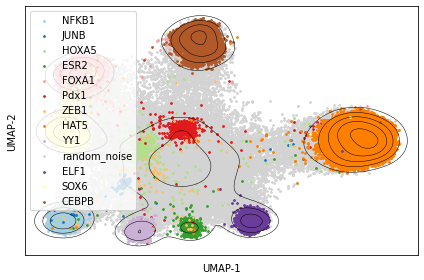

In [15]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=sns.color_palette("Paired")) 

fig, ax = plt.subplots()
for TF in set(df_UMAP["TF"].tolist()):
    if TF != "random_noise":
        subdf = df_UMAP[df_UMAP["TF"] == TF]
        ax.scatter(subdf["X"], subdf["Y"], s=3, label=TF)
    else:
        subdf = df_UMAP[df_UMAP["TF"] == TF]
        ax.scatter(subdf["X"], subdf["Y"], s=3, label=TF, zorder=0, color="lightgray")
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([df_UMAP["X"], df_UMAP["Y"]])
kernel = scipy.stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")
    
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("UMAP-ground_truth.jpg", dpi=300)
plt.legend()
plt.savefig("UMAP-ground_truth.legend.jpg", dpi=300)

HDBSCAN soft clustering time: 4.283397912979126 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 10
Cluster
-1     15263
 1     13697
 2      7259
 3     25377
 4      8136
 5      9788
 6      4391
 7       366
 8      3001
 9      5781
 10    16791
Name: Cluster, dtype: int64


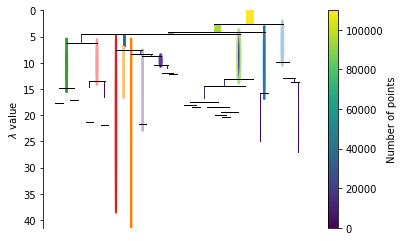

In [16]:
# #_, _, df_HDBSCAN, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=100, soft_clustering=False, optimize=True)
_, _, df_HDBSCAN, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=100, soft_clustering=False, optimize=False)

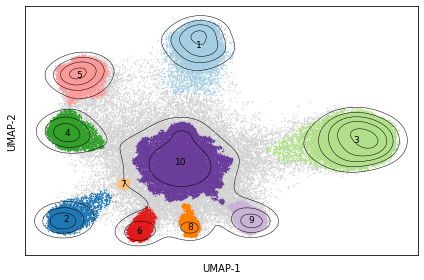

In [17]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN, title=None, cluster_col="Cluster")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("iMVP_out.jpg", dpi=300)

In [18]:
with open("sim_out.fa", "w") as output:
    for idx, row in df.iterrows():
        output.write(">{}_{}\n{}\n".format(row["TF"], idx, row["motif_F10"]))

In [19]:
extract_fasta_and_draw_motifs("iMVP_out", df_HDBSCAN)

===============  iMVP_out ===============
Cluster #1: 13697
Cluster #2: 7259
Cluster #3: 25377
Cluster #4: 8136
Cluster #5: 9788
Cluster #6: 4391
Cluster #7: 366
Cluster #8: 3001
Cluster #9: 5781
Cluster #10: 16791
Cluster #-1: 15263


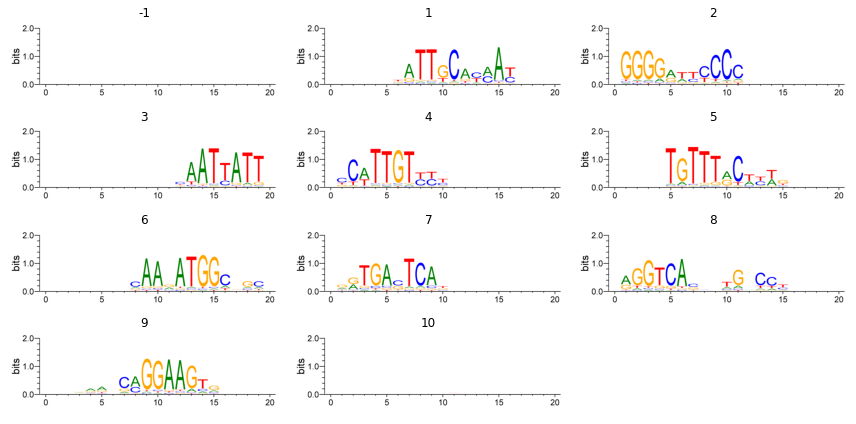

In [20]:
show_logos_cols("./iMVP_out/logos_bits_png/")

In [21]:
extract_fasta_and_draw_motifs("iMVP_out_ground_truth", df_HDBSCAN, cluster_col="TF")

===============  iMVP_out_ground_truth ===============
Cluster #NFKB1: 5000
Cluster #JUNB: 250
Cluster #HOXA5: 500
Cluster #ESR2: 2000
Cluster #FOXA1: 8000
Cluster #Pdx1: 1000
Cluster #ZEB1: 100
Cluster #HAT5: 20000
Cluster #YY1: 3000
Cluster #random_noise: 50000
Cluster #ELF1: 4000
Cluster #SOX6: 6000
Cluster #CEBPB: 10000


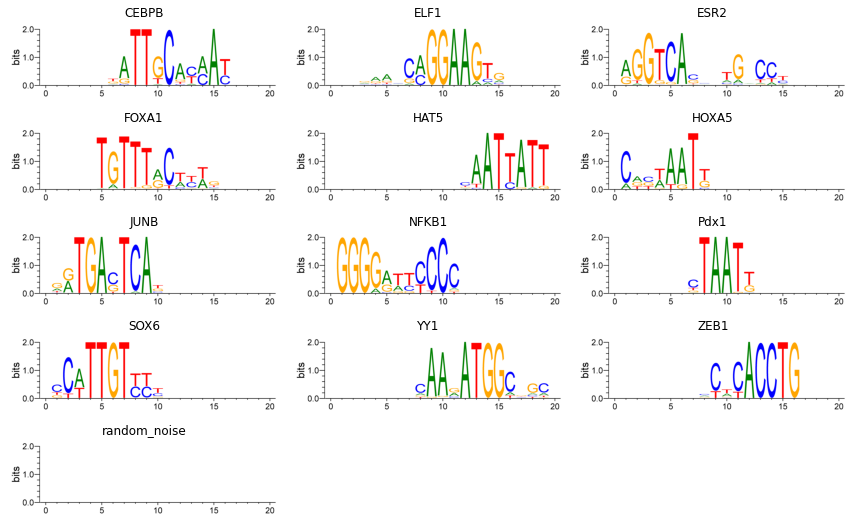

In [22]:
show_logos_cols("./iMVP_out_ground_truth/logos_bits_png/")

## HDBSCAN (not softclustering)

HDBSCAN soft clustering time: 8.652363777160645 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 10
Cluster
1     13786
2      7100
3     26053
4      9479
5     10518
6      4916
7      3326
8      3993
9      6995
10    23684
Name: Cluster, dtype: int64


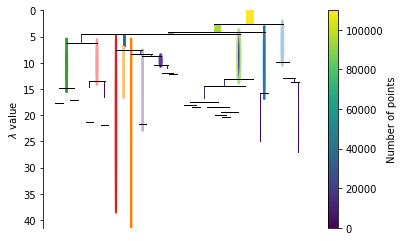

In [23]:
_, _, df_HDBSCAN_soft, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=100, soft_clustering=True, optimize=False)

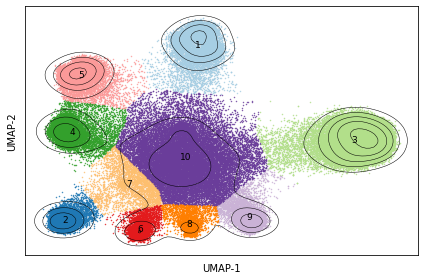

In [24]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN_soft, title=None, cluster_col="Cluster")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("iMVP_out.soft.jpg", dpi=300)

In [25]:
extract_fasta_and_draw_motifs("iMVP_out_soft", df_HDBSCAN_soft)

===============  iMVP_out_soft ===============
Cluster #1: 13786
Cluster #2: 7100
Cluster #3: 26053
Cluster #4: 9479
Cluster #5: 10518
Cluster #6: 4916
Cluster #7: 3326
Cluster #8: 3993
Cluster #9: 6995
Cluster #10: 23684


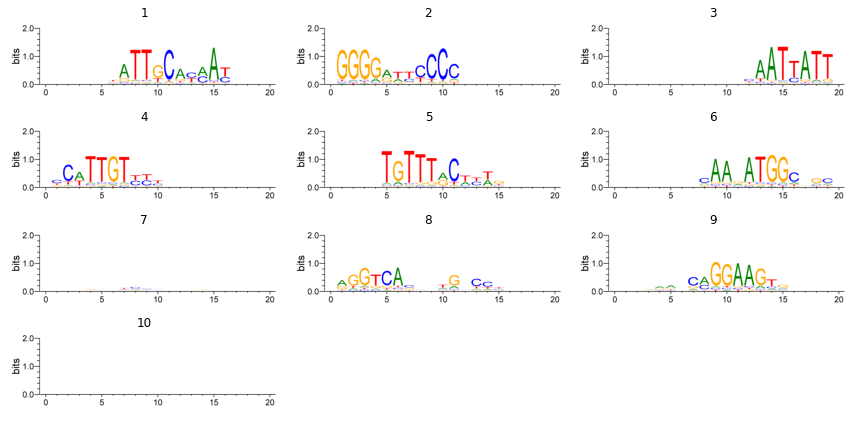

In [26]:
show_logos_cols("./iMVP_out_soft/logos_bits_png/")

## Leiden

In [27]:
from umap.umap_ import nearest_neighbors
from scipy.sparse import issparse, coo_matrix, csr_matrix
# leiden
import leidenalg
import igraph as ig

In [28]:
def get_sparse_matrix_from_indices_distances_umap(
        knn_indices, knn_dists, n_obs, n_neighbors
    ):
    from scipy.sparse import issparse, coo_matrix, csr_matrix
    rows = np.zeros((n_obs * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_obs * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_obs * n_neighbors), dtype=np.float64)

    for i in range(knn_indices.shape[0]):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            else:
                val = knn_dists[i, j]

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    result = coo_matrix((vals, (rows, cols)), shape=(n_obs, n_obs))
    result.eliminate_zeros()
    return result.tocsr()

def compute_connectivities_umap(
        knn_indices,
        knn_dists,
        n_obs,
        n_neighbors,
        set_op_mix_ratio=1.0,
        local_connectivity=1.0,
    ):
    from scipy.sparse import issparse, coo_matrix, csr_matrix
    from umap.umap_ import fuzzy_simplicial_set
    X = coo_matrix(([], ([], [])), shape=(n_obs, 1))
    connectivities = fuzzy_simplicial_set(
        X,
        n_neighbors,
        None,
        None,
        knn_indices=knn_indices,
        knn_dists=knn_dists,
        set_op_mix_ratio=set_op_mix_ratio,
        local_connectivity=local_connectivity,
    )

    if isinstance(connectivities, tuple):
        # In umap-learn 0.4, this returns (result, sigmas, rhos)
        connectivities = connectivities[0]

    distances = get_sparse_matrix_from_indices_distances_umap(
        knn_indices, knn_dists, n_obs, n_neighbors
    )

    return distances, connectivities.tocsr()

def get_igraph_from_adjacency(adjacency, directed=None):
    """Get igraph graph from adjacency matrix."""
    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))
    try:
        g.es['weight'] = weights
    except KeyError:
        pass
    return g

def get_igraph(onehot_input, random_state = 42, metric="euclidean", n_neighbors = 20, metric_kwds={}, angular=False, verbose=False):
    time0 = time.time()
    n_obs = onehot_input.shape[0]
    
    knn_indices, knn_dists, forest = nearest_neighbors(
            onehot_input,
            n_neighbors,
            random_state=random_state,
            metric=metric,
            metric_kwds=metric_kwds,
            angular=angular,
            verbose=verbose,
            n_jobs=4,
        )
      
    distances, connectivities = compute_connectivities_umap(knn_indices, knn_dists, n_obs, n_neighbors, set_op_mix_ratio=1.0, local_connectivity=1.0)
 
    g = get_igraph_from_adjacency(connectivities)
    return g, time.time() - time0

In [29]:
def cluster_Leiden(df, graph, resolution_parameter=1):
    df = df.copy()
    tracemalloc.start()
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    partition_type = leidenalg.RBConfigurationVertexPartition
    model = leidenalg.find_partition(graph, partition_type, seed=42, resolution_parameter=resolution_parameter)
    labels = model.membership
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    tracemalloc.stop()
    print("Louvain time: {} sec".format(time1))
    print("Louvain RAM: {} Mb".format(mem))
    print("==================================================")
    print()
    
    df["Cluster"] = labels
    df["Cluster"] += 1
    return time1, mem, df

In [30]:
g, time_graph = get_igraph(onehot_input)

In [31]:
t1, m1, df_leiden = cluster_Leiden(df_UMAP, g)

Louvain time: 5.278573036193848 sec
Louvain RAM: 4.608440399169922 Mb



In [32]:
def draw_one_sample2(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0, init=1):
    clusters = list([i for i in range(init, int(df[cluster_col].max())+1)]) + [-1]
    print(clusters)
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        print(subdf.shape)
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

[0, 1, 2, 3, 4, 5, 6, 7, 8, -1]
(0, 5)
(26811, 5)
(15240, 5)
(15096, 5)
(12040, 5)
(10820, 5)
(10319, 5)
(10005, 5)
(9519, 5)
(0, 5)


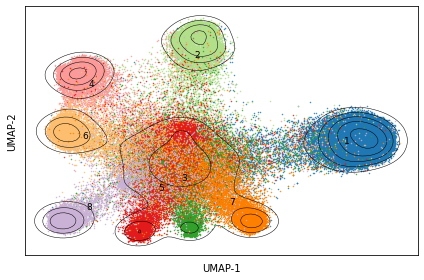

In [33]:
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=sns.color_palette("Paired")) 
fig, ax = plt.subplots()

draw_one_sample2(ax, df_leiden, title=None, cluster_col="Cluster", init=0)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("iMVP_out.leiden.jpg", dpi=300)

In [34]:
extract_fasta_and_draw_motifs("iMVP_out_leiden", df_leiden, cluster_col="Cluster")

===============  iMVP_out_leiden ===============
Cluster #1: 26811
Cluster #2: 15240
Cluster #3: 15096
Cluster #4: 12040
Cluster #5: 10820
Cluster #6: 10319
Cluster #7: 10005
Cluster #8: 9519


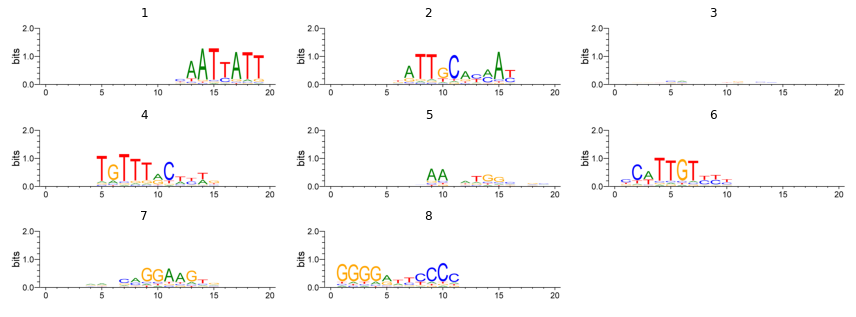

In [35]:
show_logos_cols("./iMVP_out_leiden/logos_bits_png/")

In [36]:
label_dict = {
    "CEBPB": 1,
    "ELF1": 2,
    "ESR2":	3,
    "FOXA1": 4,
    "HAT5": 5,
    "HOXA5":	6,
    "JUNB" :	7,
    "NFKB1" :	8,
    "Pdx1" :9,
    "SOX6" :	10,
    "YY1" : 11,
    "ZEB1" :12,
    "random_noise": 0,
}

In [37]:
def cal_ARI(df, name):
    # firstly, get confusion matrix
    exp_values = []
    for i in df["TF"]:
        exp_values.append(label_dict[i])
    pred_values = []
    for i in df["Cluster"]:
        pred_values.append(i)
    ARI = adjusted_rand_score(exp_values, pred_values)
    print(name, ARI)
    return ARI

In [38]:
cal_ARI(df_HDBSCAN, "HDBSCAN")

HDBSCAN 0.37774815431515424


0.37774815431515424

In [39]:
cal_ARI(df_HDBSCAN_soft, "HDBSCAN soft")

HDBSCAN soft 0.391314078157409


0.391314078157409

In [40]:
cal_ARI(df_leiden, "Leiden")

Leiden 0.2849819558798623


0.2849819558798623